In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
import pickle

In [3]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales           = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [6]:
transactions = sales
len(transactions)

2935849

In [7]:
transactions = sales
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)
transactions['y'] = transactions.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_day'].transform('sum').clip(0,40)
transactions = transactions.drop_duplicates(['date_block_num', 'item_id', 'shop_id'])
transactions = transactions[transactions['year'] != 2013]


In [87]:
len(transactions)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,y
1267562,02.01.2014,12,54,10297,749.0,1.0,2,1,2014,4.0
1267565,24.01.2014,12,54,10296,1599.0,1.0,24,1,2014,3.0
1267567,03.01.2014,12,54,10298,399.0,3.0,3,1,2014,14.0
1267570,15.01.2014,12,54,10300,699.0,1.0,15,1,2014,3.0
1267579,13.01.2014,12,54,10284,299.0,1.0,13,1,2014,1.0


In [8]:
item_ids = transactions['item_id'].unique()
shop_ids = transactions['shop_id'].unique()
months = transactions['month'].unique()
years = transactions['year'].unique()
blocks = transactions['date_block_num'].unique()

In [9]:
combinations = []
for shop_id in shop_ids:
    #get all item ever sold by this shop
    sold_items = transactions[transactions['shop_id'] == shop_id]['item_id'].unique()
    shop_combos = [[item, shop_id, block] for item in sold_items for block in blocks]
    for shop_combo in shop_combos:
        combinations.append(shop_combo)

In [11]:
combinations_test = []
for shop_id in test['shop_id'].unique():
    #get all item ever sold by this shop
    sold_items = test[test['shop_id'] == shop_id]['item_id'].unique()
    shop_combos = [[item, shop_id, block] for item in sold_items for block in blocks]
    for shop_combo in shop_combos:
        combinations_test.append(shop_combo)

In [89]:
#combinations = [[item, shop, block] for item in item_ids for shop in shop_ids for block in blocks]

In [12]:
len(combinations_test)

4712400

In [13]:
combos = pd.DataFrame(combinations, columns=['item_id', 'shop_id', 'date_block_num'])

In [14]:
combos_test = pd.DataFrame(combinations_test, columns=['item_id', 'shop_id', 'date_block_num'])

In [15]:
dates = transactions[['date_block_num', 'month', 'year']].drop_duplicates(['date_block_num', 'month', 'year'])

dates_dict = {}

for index,row in dates.iterrows():
    dates_dict[row['date_block_num']] = {"month": row['month'], "year": row['year']}
    
dates_dict

{12: {'month': 1, 'year': 2014},
 13: {'month': 2, 'year': 2014},
 14: {'month': 3, 'year': 2014},
 15: {'month': 4, 'year': 2014},
 16: {'month': 5, 'year': 2014},
 17: {'month': 6, 'year': 2014},
 18: {'month': 7, 'year': 2014},
 19: {'month': 8, 'year': 2014},
 20: {'month': 9, 'year': 2014},
 21: {'month': 10, 'year': 2014},
 22: {'month': 11, 'year': 2014},
 23: {'month': 12, 'year': 2014},
 24: {'month': 1, 'year': 2015},
 25: {'month': 2, 'year': 2015},
 26: {'month': 3, 'year': 2015},
 27: {'month': 4, 'year': 2015},
 28: {'month': 5, 'year': 2015},
 29: {'month': 6, 'year': 2015},
 30: {'month': 7, 'year': 2015},
 31: {'month': 8, 'year': 2015},
 32: {'month': 9, 'year': 2015},
 33: {'month': 10, 'year': 2015}}

In [16]:
combos['y'] = 0
combos['date'] = 0
combos['item_price'] = 0
combos['item_cnt_day'] = 0
combos['day'] = 0

combos['month'] = combos['date_block_num'].apply(lambda block: dates_dict[block]['month'])
combos['year'] = combos['date_block_num'].apply(lambda block: dates_dict[block]['year'])

In [17]:
combos_test['y'] = 0
combos_test['date'] = 0
combos_test['item_price'] = 0
combos_test['item_cnt_day'] = 0
combos_test['day'] = 0

combos_test['month'] = combos['date_block_num'].apply(lambda block: dates_dict[block]['month'])
combos_test['year'] = combos['date_block_num'].apply(lambda block: dates_dict[block]['year'])

In [18]:
concatenated = pd.concat([transactions, combos, combos_test]).reset_index()

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [19]:
concatenated[(concatenated['item_id'] == 30) & (concatenated['shop_id'] == 30)]

,index,date,date_block_num,day,item_cnt_day,item_id,item_price,month,shop_id,y,year
18340,1304858,20.01.2014,12,20,1.0,30,169.0,1,30,1.0,2014
62915,1386701,05.02.2014,13,5,1.0,30,169.0,2,30,1.0,2014
189692,1617912,18.04.2014,15,18,1.0,30,169.0,4,30,2.0,2014
247274,1718226,07.06.2014,17,7,1.0,30,169.0,6,30,1.0,2014
404913,1999587,20.09.2014,20,20,1.0,30,169.0,9,30,1.0,2014
424223,2035880,28.10.2014,21,28,1.0,30,169.0,10,30,2.0,2014
467294,2115050,27.11.2014,22,27,1.0,30,169.0,11,30,1.0,2014
595763,2375516,07.01.2015,24,7,1.0,30,169.0,1,30,1.0,2015
3086178,2164778,0,12,0,0.0,30,0.0,1,30,0.0,2014
3086179,2164779,0,13,0,0.0,30,0.0,2,30,0.0,2014


In [20]:
import pickle as pickle

pickle.dump(concatenated, open( "concatenated", "wb"))

#concatenated = pickle.load( open( "concatenated", "rb" ) )

In [21]:
concatenated = concatenated.drop_duplicates(['item_id', 'shop_id', 'month', 'year'], keep="first")

In [22]:
concatenated[(concatenated['item_id'] == 30) & (concatenated['shop_id'] == 30)]

,index,date,date_block_num,day,item_cnt_day,item_id,item_price,month,shop_id,y,year
18340,1304858,20.01.2014,12,20,1.0,30,169.0,1,30,1.0,2014
62915,1386701,05.02.2014,13,5,1.0,30,169.0,2,30,1.0,2014
189692,1617912,18.04.2014,15,18,1.0,30,169.0,4,30,2.0,2014
247274,1718226,07.06.2014,17,7,1.0,30,169.0,6,30,1.0,2014
404913,1999587,20.09.2014,20,20,1.0,30,169.0,9,30,1.0,2014
424223,2035880,28.10.2014,21,28,1.0,30,169.0,10,30,2.0,2014
467294,2115050,27.11.2014,22,27,1.0,30,169.0,11,30,1.0,2014
595763,2375516,07.01.2015,24,7,1.0,30,169.0,1,30,1.0,2015
3086180,2164780,0,14,0,0.0,30,0.0,3,30,0.0,2014
3086182,2164782,0,16,0,0.0,30,0.0,5,30,0.0,2014


In [23]:
len(concatenated)

8333930

In [37]:
len(transactions)

921400

In [147]:
w_cat_ids = concatenated.set_index('item_id').join(items.set_index('item_id'))

In [148]:
w_cat_ids['item_mean'] = w_cat_ids.groupby(['item_id'])['y'].transform('mean')
w_cat_ids['item_mean_month'] = w_cat_ids.groupby(['item_id', 'date_block_num'])['y'].transform('mean')
w_cat_ids['shop_mean_month'] = w_cat_ids.groupby(['shop_id', 'date_block_num'])['y'].transform('mean')
w_cat_ids['category_mean_month'] = w_cat_ids.groupby(['item_category_id', 'date_block_num'])['y'].transform('mean')
w_cat_ids['shop_category_mean_month'] = w_cat_ids.groupby(['shop_id','item_category_id', 'date_block_num'])['y'].transform('mean')
w_cat_ids['item_shop_month'] = w_cat_ids.groupby(['shop_id','item_id', 'date_block_num'])['y'].transform('mean')

In [149]:
X = w_cat_ids.reset_index()

In [150]:
rollings = X[['item_mean_month', 'date_block_num', 'item_id']].copy()
rollings = rollings.drop_duplicates(['item_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_id'])
a = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(1)
aa = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(3)
aaa = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(6)
aaaa = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(2)
aaaaa = rollings.sort_values(['item_id', 'date_block_num'])\
        .groupby(['item_id'])['item_mean_month'].shift(12)

In [151]:
b = pd.DataFrame(a)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [152]:
b = pd.DataFrame(aa)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [153]:
b = pd.DataFrame(aaa)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [154]:
b = pd.DataFrame(aaaa)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_2'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [155]:
b = pd.DataFrame(aaaaa)
b.rename(columns={'item_mean_month': 'item_mean_month_minus_12'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'date_block_num'], how='left')

In [156]:
rollings = X[['shop_mean_month', 'date_block_num', 'shop_id']].copy()
rollings = rollings.drop_duplicates(['shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'shop_id'])
a = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(1)
aa = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(3)
aaa = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(6)
aaaa = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(2)
aaaaa = rollings.sort_values(['shop_id', 'date_block_num'])\
        .groupby(['shop_id'])['shop_mean_month'].shift(12)

In [157]:
b = pd.DataFrame(a)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [158]:
b = pd.DataFrame(aa)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [159]:
b = pd.DataFrame(aaa)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [160]:
b = pd.DataFrame(aaaa)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_2'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [161]:
b = pd.DataFrame(aaaaa)
b.rename(columns={'shop_mean_month': 'shop_mean_month_minus_12'}, inplace=True)

X = pd.merge(X, b, on=['shop_id', 'date_block_num'], how='left')

In [162]:
rollings = X[['category_mean_month', 'date_block_num', 'item_category_id']].copy()
rollings = rollings.drop_duplicates(['item_category_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_category_id'])
a = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(1)
aa = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(3)
aaa = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(6)
aaaa = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(2)
aaaaa = rollings.sort_values(['item_category_id', 'date_block_num'])\
        .groupby(['item_category_id'])['category_mean_month'].shift(12)

In [163]:
b = pd.DataFrame(a)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [164]:
b = pd.DataFrame(aa)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [165]:
b = pd.DataFrame(aaa)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [166]:
b = pd.DataFrame(aaaa)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_2'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [167]:
b = pd.DataFrame(aaaaa)
b.rename(columns={'category_mean_month': 'category_mean_month_minus_12'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'date_block_num'], how='left')

In [168]:
rollings = X[['shop_category_mean_month', 'date_block_num', 'shop_id', 'item_category_id']].copy()
rollings = rollings.drop_duplicates(['item_category_id', 'shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_category_id', 'shop_id'])
a = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(1)
aa = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(3)
aaa = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(6)
aaaa = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(2)
aaaaa = rollings.sort_values(['item_category_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_category_id', 'shop_id'])['shop_category_mean_month'].shift(12)

In [169]:
gc.collect()
b = pd.DataFrame(a)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [170]:
b = pd.DataFrame(aa)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [171]:
b = pd.DataFrame(aaa)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [172]:
b = pd.DataFrame(aaaa)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_2'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [173]:
b = pd.DataFrame(aaaaa)
b.rename(columns={'shop_category_mean_month': 'shop_category_mean_month_minus_12'}, inplace=True)

X = pd.merge(X, b, on=['item_category_id', 'shop_id', 'date_block_num'], how='left')

In [174]:
rollings = X[['item_shop_month', 'date_block_num', 'shop_id', 'item_id']].copy()
rollings = rollings.drop_duplicates(['item_id', 'shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_id', 'shop_id'])
a = rollings.sort_values(['item_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_id', 'shop_id'])['item_shop_month'].shift(1)
aa = rollings.sort_values(['item_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_id', 'shop_id'])['item_shop_month'].shift(3)
aaa = rollings.sort_values(['item_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_id', 'shop_id'])['item_shop_month'].shift(6)
aaaa = rollings.sort_values(['item_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_id', 'shop_id'])['item_shop_month'].shift(2)
aaaaa = rollings.sort_values(['item_id', 'shop_id', 'date_block_num'])\
        .groupby(['item_id', 'shop_id'])['item_shop_month'].shift(12)

In [175]:
b = pd.DataFrame(a)
b.rename(columns={'item_shop_month': 'item_shop_month_minus_1'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'shop_id', 'date_block_num'], how='left')

In [176]:
b = pd.DataFrame(aa)
b.rename(columns={'item_shop_month': 'item_shop_month_minus_3'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'shop_id', 'date_block_num'], how='left')

In [177]:
b = pd.DataFrame(aaa)
b.rename(columns={'item_shop_month': 'item_shop_month_minus_6'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'shop_id', 'date_block_num'], how='left')

In [178]:
b = pd.DataFrame(aaaa)
b.rename(columns={'item_shop_month': 'item_shop_month_minus_2'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'shop_id', 'date_block_num'], how='left')

In [179]:
b = pd.DataFrame(aaaaa)
b.rename(columns={'item_shop_month': 'item_shop_month_minus_12'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'shop_id', 'date_block_num'], how='left')

In [180]:
for dtype in ['float','int','object']:
    selected_dtype = X.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 63.58 MB
Average memory usage for int columns: 63.58 MB
Average memory usage for object columns: 534.46 MB


In [181]:
X.drop(['item_name', 'date', 'day','item_price'], axis=1, inplace=True)

In [182]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

X_int = X.select_dtypes(include=['int'])
converted_int = X_int.apply(pd.to_numeric,downcast='unsigned')

print(mem_usage(X_int))
print(mem_usage(converted_int))

compare_ints = pd.concat([X_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

63.58 MB
63.58 MB


,before,after


In [183]:
X_float = X.select_dtypes(include=['float'])
converted_float = X_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(X_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([X_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

2161.82 MB
1112.70 MB


,before,after
float32,NaN,33.0
float64,33.0,NaN


In [184]:
optimized_X = X.copy()

optimized_X[converted_int.columns] = converted_int
optimized_X[converted_float.columns] = converted_float

print(mem_usage(X))
print(mem_usage(optimized_X))

2606.90 MB
1557.78 MB


In [185]:
X = optimized_X

In [186]:
pickle.dump(X, open( "optimized_X", "wb"))

#X = pickle.load( open( "optimized_X", "rb" ) )

In [76]:
X[(X['item_id'] == 30) & (X['shop_id'] == 30)]\
        .sort_values(['shop_id','item_id','date_block_num'])\
        .groupby(['shop_id','item_id','date_block_num'])\
        ['item_shop_month'].first().rolling(3).mean().shift(1)

shop_id  item_id  date_block_num
30       30       12                     NaN
                  13                     NaN
                  14                     NaN
                  15                0.666667
                  16                1.000000
                  17                0.666667
                  18                1.000000
                  19                0.333333
                  20                0.333333
                  21                0.333333
                  22                1.000000
                  23                1.333333
                  24                1.000000
                  25                0.666667
                  26                0.333333
                  27                0.333333
                  28                0.000000
                  29                0.000000
                  30                0.000000
                  31                0.000000
                  32                0.000000
                  33  

In [194]:
rollings = X[['item_shop_month', 'date_block_num', 'shop_id', 'item_id']].copy()
rollings = rollings.drop_duplicates(['item_id', 'shop_id', 'date_block_num'])
rollings = rollings.set_index(['date_block_num', 'item_id', 'shop_id'])
a = rollings.sort_values(['item_id', 'shop_id', 'date_block_num'])\
        .groupby(['shop_id','item_id','date_block_num'])['item_shop_month'].first().rolling(3).mean().shift(1)


In [195]:
b = pd.DataFrame(a)

b.rename(columns={'item_shop_month': 'item_shop_month_rolling_3'}, inplace=True)

X = pd.merge(X, b, on=['item_id', 'shop_id', 'date_block_num'], how='left')

In [81]:
X[(X['item_id'] == 30) & (X['shop_id'] == 30)].drop_duplicates(['item_id', 'shop_id', 'date_block_num'])[['item_id', 'shop_id', 'month', 'year', 'item_shop_month', 'item_shop_month_rolling_3']]

,item_id,shop_id,month,year,item_shop_month,item_shop_month_rolling_3
732,30,30,1,2014,1.0,0.000000
755,30,30,2,2014,1.0,0.333333
800,30,30,4,2014,2.0,0.666667
816,30,30,6,2014,1.0,0.666667
850,30,30,9,2014,1.0,0.333333
854,30,30,10,2014,2.0,0.333333
862,30,30,11,2014,1.0,1.000000
886,30,30,1,2015,1.0,1.000000
1168,30,30,3,2014,0.0,0.666667
1169,30,30,5,2014,0.0,1.000000


In [187]:
X.columns

Index(['item_id', 'index', 'date_block_num', 'item_cnt_day', 'month',
       'shop_id', 'y', 'year', 'item_category_id', 'item_mean',
       'item_mean_month', 'shop_mean_month', 'category_mean_month',
       'shop_category_mean_month', 'item_shop_month',
       'item_mean_month_minus_1', 'item_mean_month_minus_3',
       'item_mean_month_minus_6', 'item_mean_month_minus_2',
       'item_mean_month_minus_12', 'shop_mean_month_minus_1',
       'shop_mean_month_minus_3', 'shop_mean_month_minus_6',
       'shop_mean_month_minus_2', 'shop_mean_month_minus_12',
       'category_mean_month_minus_1', 'category_mean_month_minus_3',
       'category_mean_month_minus_6', 'category_mean_month_minus_2',
       'category_mean_month_minus_12', 'shop_category_mean_month_minus_1',
       'shop_category_mean_month_minus_3', 'shop_category_mean_month_minus_6',
       'shop_category_mean_month_minus_2', 'shop_category_mean_month_minus_12',
       'item_shop_month_minus_1', 'item_shop_month_minus_3',
    

In [139]:
X[(X['item_id'] == 30) & (X['shop_id'] == 30)].drop_duplicates(['item_id', 'shop_id', 'date_block_num'])[['item_id', 'shop_id', 'month', 'year', 'item_shop_month', 'item_shop_month_minus_1', 'item_shop_month_minus_3', 'item_shop_month_minus_6']]

,item_id,shop_id,month,year,item_shop_month,item_shop_month_minus_1,item_shop_month_minus_3,item_shop_month_minus_6
732,30,30,1,2014,1.0,NaN,NaN,NaN
755,30,30,2,2014,1.0,1.0,NaN,NaN
800,30,30,4,2014,2.0,0.0,1.0,NaN
816,30,30,6,2014,1.0,0.0,0.0,NaN
850,30,30,9,2014,1.0,0.0,1.0,0.0
854,30,30,10,2014,2.0,1.0,0.0,2.0
862,30,30,11,2014,1.0,2.0,0.0,0.0
886,30,30,1,2015,1.0,0.0,2.0,0.0
1168,30,30,3,2014,0.0,1.0,NaN,NaN
1169,30,30,5,2014,0.0,2.0,1.0,NaN


In [134]:
X[X['item_id'] == 30].drop_duplicates(['item_id', 'date_block_num'])[['item_id', 'month', 'year', 'item_mean_month', 'item_mean_month_minus_1', 'item_mean_month_minus_3', 'item_mean_month_minus_6']]

,item_id,month,year,item_mean_month,item_mean_month_minus_1,item_mean_month_minus_3,item_mean_month_minus_6
33880,30,1,2014,1.894737,NaN,NaN,NaN
33907,30,2,2014,1.266667,1.894737,NaN,NaN
33925,30,3,2014,1.714286,1.266667,NaN,NaN
33941,30,4,2014,1.388889,1.714286,1.894737,NaN
33955,30,5,2014,1.235294,1.388889,1.266667,NaN
33968,30,6,2014,1.133333,1.235294,1.714286,NaN
33979,30,7,2014,1.214286,1.133333,1.388889,1.894737
33990,30,8,2014,1.285714,1.214286,1.235294,1.266667
33998,30,9,2014,1.166667,1.285714,1.133333,1.714286
34007,30,10,2014,1.555556,1.166667,1.214286,1.388889


In [59]:
X[X['shop_id'] == 30].drop_duplicates(['shop_id', 'date_block_num'])[['shop_id', 'month', 'year', 'shop_mean_month', 'shop_mean_month_minus_1', 'shop_mean_month_minus_3', 'shop_mean_month_minus_6']]

,shop_id,month,year,shop_mean_month,shop_mean_month_minus_1,shop_mean_month_minus_3,shop_mean_month_minus_6
11,30,11,2014,1.873958,NaN,NaN,NaN
35,30,1,2015,1.736099,2.118103,NaN,NaN
130,30,2,2015,1.670232,1.736099,1.873958,NaN
245,30,12,2014,2.118103,1.873958,NaN,NaN


In [60]:
X[X['item_category_id'] == 30].drop_duplicates(['item_category_id', 'date_block_num'])[['item_category_id', 'month', 'year', 'category_mean_month', 'category_mean_month_minus_1']]

,item_category_id,month,year,category_mean_month,category_mean_month_minus_1
3762,30,10,2015,3.070205,2.746511
11027,30,1,2015,3.009862,3.101948
11028,30,7,2015,2.670056,2.788012
12837,30,11,2014,2.843284,NaN
12854,30,12,2014,3.101948,2.843284
12897,30,2,2015,2.905608,3.009862
12904,30,3,2015,2.889822,2.905608
12913,30,4,2015,2.892322,2.889822
12925,30,5,2015,2.702312,2.892322
12933,30,6,2015,2.788012,2.702312


In [61]:
X[(X['item_category_id'] == 30) & (X['shop_id'] == 30)].drop_duplicates(['item_category_id', 'shop_id', 'date_block_num'])[['item_category_id', 'shop_id' ,  'month', 'year', 'shop_category_mean_month', 'shop_category_mean_month_minus_1']]

,item_category_id,shop_id,month,year,shop_category_mean_month,shop_category_mean_month_minus_1
16939,30,30,11,2014,1.864198,NaN
16992,30,30,12,2014,2.421687,1.864198
17043,30,30,1,2015,2.597633,2.421687
17087,30,30,2,2015,2.488550,2.597633


In [140]:
X.columns

Index(['item_id', 'index', 'date', 'date_block_num', 'day', 'item_cnt_day',
       'item_price', 'month', 'shop_id', 'y', 'year', 'item_name',
       'item_category_id', 'item_mean', 'item_mean_month', 'shop_mean_month',
       'category_mean_month', 'shop_category_mean_month', 'item_shop_month',
       'item_mean_month_minus_1', 'item_mean_month_minus_3',
       'item_mean_month_minus_6', 'shop_mean_month_minus_1',
       'shop_mean_month_minus_3', 'shop_mean_month_minus_6',
       'category_mean_month_minus_1', 'category_mean_month_minus_3',
       'category_mean_month_minus_6', 'shop_category_mean_month_minus_1',
       'shop_category_mean_month_minus_3', 'shop_category_mean_month_minus_6',
       'item_shop_month_minus_1', 'item_shop_month_minus_3',
       'item_shop_month_minus_6'],
      dtype='object')

In [141]:
columns = X.columns
percent_missing = X.isna().sum() * 100 / len(X)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
item_id,item_id,0.000000
index,index,0.000000
date,date,0.000000
date_block_num,date_block_num,0.000000
day,day,0.000000
item_cnt_day,item_cnt_day,0.000000
item_price,item_price,0.000000
month,month,0.000000
shop_id,shop_id,0.000000
y,y,0.000000


In [64]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [188]:
#features = ['item_id', 'date_block_num', 'shop_id', #'item_price',
lgbm_features = [#'item_id', 'shop_id', 'item_category_id',# 'year',,  'month'
       #'item_mean', 
       #         'item_mean_month', 'shop_mean_month','category_mean_month','shop_category_mean_month', 'item_shop_month',   
       'item_mean_month_minus_1', 'item_mean_month_minus_3',
       'item_mean_month_minus_6', 'item_mean_month_minus_2','item_mean_month_minus_12',
    'shop_mean_month_minus_1',
       'shop_mean_month_minus_3', 'shop_mean_month_minus_6','shop_mean_month_minus_2', 'shop_mean_month_minus_12',
       'category_mean_month_minus_1', 'category_mean_month_minus_3',
       'category_mean_month_minus_6', 'category_mean_month_minus_2', 'category_mean_month_minus_12', 
    'shop_category_mean_month_minus_1',
       'shop_category_mean_month_minus_3', 'shop_category_mean_month_minus_6', 'shop_category_mean_month_minus_2', 'shop_category_mean_month_minus_12',
         #'item_shop_month_minus_1', 'item_shop_month_minus_3',
      #'item_shop_month_minus_6', 'item_shop_month_minus_1', 'item_shop_month_minus_12',
    'item_shop_month_rolling_3'
                ]
    
lr_features = [
       #'item_mean', 'item_mean_month', 'shop_mean_month',
       #'category_mean_month', 'shop_category_mean_month',
       'item_mean_month_minus_1', 
       'shop_mean_month_minus_1',
       'category_mean_month_minus_1',
       'shop_category_mean_month_minus_1','item_shop_month_minus_1']


In [189]:
val_indices = X[(X['year'] == 2015) & (X['month'].isin([9,10]))].index

In [197]:
x = X
y = X['y']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [191]:
x_train.shape

(7576300, 40)

In [192]:
gc.collect()

112

In [198]:
gc.collect()
lgtrain = lgbm.Dataset(x_train[lgbm_features], label=y_train)
lgval = lgbm.Dataset(x_val[lgbm_features], label=y_val)



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 16,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        #"max_bin": 10,#default 255
        #"num_leaves": 10, #default 31
        "bagging_fraction": 0.2,
        "bagging_freq": 1,
        "min_data_in_leaf": 500000,
        "feature_fraction": 0.7,
        #"lambda_l2": 3,
        #"max_depth": 2,
        #"min_gain_to_split": 10,
        "learning_rate" : 0.01,
        #"histogram_pool_size": 1000,
        #"categorical_column": [0,1,2,3,4]
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)



Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.87826
[200]	valid_0's rmse: 0.871477
[300]	valid_0's rmse: 0.868397
[400]	valid_0's rmse: 0.866792
[500]	valid_0's rmse: 0.865807
[600]	valid_0's rmse: 0.865021
[700]	valid_0's rmse: 0.864387
[800]	valid_0's rmse: 0.863931
[900]	valid_0's rmse: 0.863534
[1000]	valid_0's rmse: 0.86319
[1100]	valid_0's rmse: 0.862871
[1200]	valid_0's rmse: 0.86259
[1300]	valid_0's rmse: 0.862314
[1400]	valid_0's rmse: 0.86208
[1500]	valid_0's rmse: 0.861838
[1600]	valid_0's rmse: 0.861614
[1700]	valid_0's rmse: 0.861423
[1800]	valid_0's rmse: 0.86125
[1900]	valid_0's rmse: 0.861045
[2000]	valid_0's rmse: 0.860883
[2100]	valid_0's rmse: 0.860766
[2200]	valid_0's rmse: 0.860617
[2300]	valid_0's rmse: 0.860499
[2400]	valid_0's rmse: 0.860341
[2500]	valid_0's rmse: 0.860202
[2600]	valid_0's rmse: 0.860074
[2700]	valid_0's rmse: 0.859936
[2800]	valid_0's rmse: 0.859833
[2900]	valid_0's rmse: 0.859717
[3000]	valid_0's rmse: 

In [44]:
X['date_block_num'].unique()

array([20, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33], dtype=uint64)

In [104]:
#pickle.dump(model_lgb, open( "model_lgb", "wb"))

model_lgb = pickle.load( open( "model_lgb", "rb" ) )

In [49]:
x_train_lr = x[~x.index.isin(val_indices)].copy()[lr_features]
x_train_lr.fillna(x_train_lr.mean(), inplace=True)

x_val_lr = x[x.index.isin(val_indices)].copy()[lr_features]
x_val_lr.fillna(x_train_lr.mean(), inplace=True)


lr_model = Ridge(alpha=0.5)
lr_model.fit(x_train_lr, y_train)

from sklearn.metrics import mean_squared_error
from math import sqrt

lr_val_preds = lr_model.predict(x_val_lr)
lr_val_preds.clip(0,20,out=lr_val_preds)
rms = sqrt(mean_squared_error(y_val, lr_val_preds))
print("rmse: ", rms)

rmse:  0.4872290096951795


In [98]:
train_meta['date_block_num'].unique()

array([28, 29, 30, 31, 32, 33])

In [72]:
#stacking
blocks = [28, 29, 30, 31, 32, 33]

train_meta = X.copy()
train_meta = train_meta.sort_values(by=['date_block_num']).reset_index()

In [ ]:
lr_preds = np.zeros(len(train_meta))


for block in blocks:
    
    fold = train_meta[train_meta['date_block_num'] == block]
    train = train_meta[train_meta['date_block_num'] < block]
    y = train['y']
    
    #lr
    x_lr = train[lr_features].copy()
    x_lr.fillna(x_lr.mean(), inplace=True)
    
    lr_model = Ridge(alpha=0.5)
    lr_model.fit(x_lr, y)
    oof = fold[lr_features].copy()
    oof.fillna(oof.mean(), inplace=True)
    oof_pred = lr_model.predict(oof)
    oof_pred.clip(0,20,out=oof_pred)

    lr_preds[fold.index] = oof_pred
    
train_meta['lr_pred'] = lr_preds

In [169]:
lgbm_preds = np.zeros(len(train_meta))

if False:
#for block in blocks:
    
    fold = train_meta[train_meta['date_block_num'] == block]
    train = train_meta[train_meta['date_block_num'] < block]
    y = train['y']
    
    #lgbm
    val_len = int(10 * len(train) / 100)
    print(val_len)
    val_indices = sorted(train.index)[-val_len:]


    x_train = train[~train.index.isin(val_indices)]
    y_train = y[~y.index.isin(val_indices)]

    x_val = train[train.index.isin(val_indices)]
    y_val = y[y.index.isin(val_indices)]
    
    
    
    lgtrain = lgbm.Dataset(x_train[lgbm_features], label=y_train, categorical_feature=[0,1,2,3])
    lgval = lgbm.Dataset(x_val[lgbm_features], label=y_val, categorical_feature=[0,1,2,3])
    
    
    
    params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        #"max_bin": 10,
        #"num_leaves": 10,
        "bagging_fraction": 0.3,
        "bagging_freq": 1,
        "min_data_in_leaf": 50000,
        "feature_fraction": 0.5,
        #"lambda_l2": 3,
        #"max_depth": 2,
        "learning_rate" : 0.01
    }

    evals_result = {}
    model_lgb = lgbm.train(params, lgtrain, 50000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=500, 
                      evals_result=evals_result)
    
    oof = fold[lgbm_features]

    oof_preds = model_lgb.predict(oof)
    oof_preds.clip(0,20,out=oof_preds)

    lgbm_preds[fold.index] = oof_preds
    
train_meta['lgbm_pred'] = lgbm_preds

NameError: name 'train_meta' is not defined

In [77]:
import pickle

lgbm_preds = pickle.load( open( "lgbm_pred", "rb" ) )
train_meta['lgbm_pred'] = lgbm_preds

In [97]:
train_meta_train = train_meta[train_meta['date_block_num'].isin([28, 29, 30, 31, 32])]
train_meta_val = train_meta[train_meta['date_block_num'].isin([33])]

meta_features = ['lr_pred', 'lgbm_pred']


meta_model = LinearRegression().fit(train_meta_train[meta_features], train_meta_train['y'])

meta_preds = meta_model.predict(train_meta_val[meta_features])
meta_preds.clip(0,20,out=meta_preds)
rms = sqrt(mean_squared_error(train_meta_val['y'], meta_preds))
print("rmse: ", rms)

rmse:  1.5580748985261248


In [199]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [200]:
test_w_cat_ids['month'] = 11
test_w_cat_ids['year'] = 2015

In [201]:
item_level = X.drop_duplicates(['item_id'])[['item_id','item_mean']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_level, on=['item_id'], how='left')

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'item_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [202]:
item_month_level_ = X[(X.month == 10) & (X.year == 2015)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [203]:
item_month_level_ = X[(X.month == 8)  & (X.year == 2015)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [204]:
item_month_level_ = X[(X.month == 5)  & (X.year == 2015)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [205]:
item_month_level_ = X[(X.month == 9)  & (X.year == 2015)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [206]:
item_month_level_ = X[(X.month == 11)  & (X.year == 2014)].drop_duplicates(['item_id'])[['item_id','item_mean_month']]\
                                   .copy().rename(columns={'item_mean_month':'item_mean_month_minus_12'})


test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level_, on=['item_id'], how='left')

In [207]:
shop_month_level_ = X[(X.month == 10)  & (X.year == 2015)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [208]:
shop_month_level_ = X[(X.month == 8)  & (X.year == 2015)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [209]:
shop_month_level_ = X[(X.month == 5)  & (X.year == 2015)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [210]:
shop_month_level_ = X[(X.month == 2)  & (X.year == 2015)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [211]:
shop_month_level_ = X[(X.month == 11)  & (X.year == 2014)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month']]\
                                   .copy().rename(columns={'shop_mean_month':'shop_mean_month_minus_12'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level_, on=['shop_id'], how='left')

In [212]:
cat_month_level_ = X[(X.month == 10) & (X.year == 2015)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [213]:
cat_month_level_ = X[(X.month == 8) & (X.year == 2015)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [214]:
cat_month_level_ = X[(X.month == 5) & (X.year == 2015)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [215]:
cat_month_level_ = X[(X.month == 9) & (X.year == 2015)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [216]:
cat_month_level_ = X[(X.month == 11) & (X.year == 2014)].drop_duplicates(['item_category_id'])[['item_category_id','category_mean_month']]\
                                   .copy().rename(columns={'category_mean_month':'category_mean_month_minus_12'})


test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level_, on=['item_category_id'], how='left')

In [217]:
shop_cat_month_level_ = X[(X.month == 10) & (X.year == 2015)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [218]:
shop_cat_month_level_ = X[(X.month == 8) & (X.year == 2015)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [219]:
shop_cat_month_level_ = X[(X.month == 5) & (X.year == 2015)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [220]:
shop_cat_month_level_ = X[(X.month == 9) & (X.year == 2015)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_2'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [221]:
shop_cat_month_level_ = X[(X.month == 11) & (X.year == 2014)].drop_duplicates(['item_category_id', 'shop_id'])[['item_category_id', 'shop_id', 'shop_category_mean_month']]\
                                   .copy().rename(columns={'shop_category_mean_month':'shop_category_mean_month_minus_12'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_cat_month_level_, on=['item_category_id', 'shop_id'], how='left')

In [222]:
shop_item_month_level_ = X[(X.month == 10) & (X.year == 2015)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'item_shop_month']]\
                                   .copy().rename(columns={'item_shop_month':'item_shop_month_minus_1'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_, on=['item_id', 'shop_id'], how='left')

In [223]:
shop_item_month_level_ = X[(X.month == 8) & (X.year == 2015)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'item_shop_month']]\
                                   .copy().rename(columns={'item_shop_month':'item_shop_month_minus_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_, on=['item_id', 'shop_id'], how='left')

In [224]:
shop_item_month_level_ = X[(X.month == 5) & (X.year == 2015)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'item_shop_month']]\
                                   .copy().rename(columns={'item_shop_month':'item_shop_month_minus_6'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_, on=['item_id', 'shop_id'], how='left')

In [228]:
shop_item_month_level_ = X[(X.month == 11) & (X.year == 2014)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'item_shop_month']]\
                                   .copy().rename(columns={'item_shop_month':'item_shop_month_minus_12'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_, on=['item_id', 'shop_id'], how='left')

In [225]:
shop_item_month_level_ = X[(X.month == 10) & (X.year == 2015)].drop_duplicates(['item_id', 'shop_id'])[['item_id', 'shop_id', 'item_shop_month']]\
                                   .copy().rename(columns={'item_shop_month':'item_shop_month_rolling_3'})


test_w_cat_ids = pd.merge(test_w_cat_ids, shop_item_month_level_, on=['item_id', 'shop_id'], how='left')

In [130]:
# stacking, we have model_lgb and lr_model fit on entire training, we predict for test

x_lr_test = test_w_cat_ids[lr_features].copy()
x_lr_test.fillna(x_lr.mean(), inplace=True)

test_lr_pred = lr_model.predict(x_lr_test[lr_features])
test_lr_pred.clip(0,20,out=test_lr_pred)


test_lgbm_preds = model_lgb.predict(test_w_cat_ids[lgbm_features])
test_lgbm_preds.clip(0,20,out=test_lgbm_preds)



array([ 1.06749073,  1.0895982 ,  1.08557396, ...,  1.27861283,
        1.26062962,  1.35388615])

In [131]:
test_meta = pd.DataFrame()
test_meta['lr_pred'] = test_lr_pred
test_meta['lgbm_pred'] = test_lgbm_preds


final_preds = meta_model.predict(test_meta)


submission = test.loc[:,['ID']]
submission['item_cnt_month'] = final_preds.astype(int)

submission.to_csv('submission.csv', index=False)

In [37]:
test_w_cat_ids[lgbm_features].head()

,item_id,shop_id,month,item_category_id,item_mean,item_mean_month_minus_1,item_mean_month_minus_3,item_mean_month_minus_6,shop_mean_month_minus_1,shop_mean_month_minus_3,shop_mean_month_minus_6,category_mean_month_minus_1,category_mean_month_minus_3,category_mean_month_minus_6,shop_category_mean_month_minus_1,shop_category_mean_month_minus_3,shop_category_mean_month_minus_6,item_shop_month_minus_1,item_shop_month_minus_3,item_shop_month_minus_6
0,30,5,11,40,0.24876,0.018182,0.109091,0.090909,0.060338,0.073414,0.055764,0.036738,0.040658,0.043792,0.036421,0.050409,0.031407,0.0,1.0,0.0
1,30,4,11,40,0.24876,0.018182,0.109091,0.090909,0.043861,0.050897,0.047086,0.036738,0.040658,0.043792,0.026392,0.024809,0.028504,0.0,0.0,0.0
2,30,6,11,40,0.24876,0.018182,0.109091,0.090909,0.098335,0.090008,0.084144,0.036738,0.040658,0.043792,0.057007,0.044075,0.045395,0.0,0.0,0.0
3,30,3,11,40,0.24876,0.018182,0.109091,0.090909,0.035945,0.037880,0.041163,0.036738,0.040658,0.043792,0.020322,0.016891,0.013988,0.0,0.0,0.0
4,30,2,11,40,0.24876,0.018182,0.109091,0.090909,0.042043,0.055236,0.041867,0.036738,0.040658,0.043792,0.019530,0.021906,0.015307,0.0,0.0,0.0


In [125]:
columns = X.columns
percent_missing = X.isna().sum() * 100 / len(X)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
item_id,item_id,0.000000
date,date,0.000000
date_block_num,date_block_num,0.000000
shop_id,shop_id,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000
item_name,item_name,0.000000


In [126]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
month,month,0.000000
item_mean,item_mean,8.843137
item_price,item_price,8.843137
item_mean_month,item_mean_month,51.509804
item_mean_month_minus_1,item_mean_month_minus_1,21.745098


In [52]:
x_lr_test = test_w_cat_ids[lr_features].copy()
x_lr_test.fillna(x_lr_test.mean(), inplace=True)


lr_preds = lr_model.predict(x_lr_test)
lr_preds.clip(0,20,out=lr_preds)



array([0.01679102, 0.01182681, 0.02716022, ..., 0.15235307, 0.155364  ,
       0.15498587])

In [94]:
w_cat_ids.shape

(20635340, 17)

In [229]:
preds = model_lgb.predict(test_w_cat_ids[lgbm_features])
preds.clip(0,20,out=preds)

array([0.        , 0.        , 0.        , ..., 0.17620309, 0.19398607,
       0.1569089 ])

In [182]:
len(np.unique(preds))

38640

In [56]:
#ensemble
ensemble_preds = np.mean(np.array([preds, lr_preds]), axis=0)

In [230]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)
#submission['item_cnt_month'] = ensemble_preds.astype(int)


submission.to_csv('submission.csv', index=False)

Plotting feature importances...


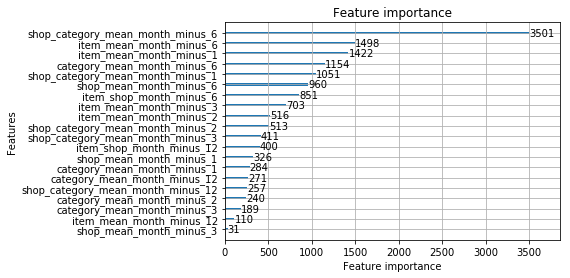

In [227]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit